In [3]:
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import importlib
import sys

keras = tf.keras
tf.enable_eager_execution()

import matplotlib.pyplot as plt

In [40]:
from euler_self_tf import euler_self_tlist, euler_sde
importlib.reload(sys.modules['euler_self_tf'])
import models as md
importlib.reload(sys.modules['models'])

<module 'models' from '/Users/rowanbrackston/Box Sync/GitRepos/NN-control/minimal_neural_ode/models.py'>

# Perturbed oscillator as neural SDE (no control yet)

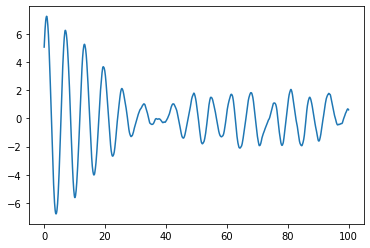

In [30]:
time_steps = 1000
t_free = np.linspace(0, 100, time_steps)
y0_free = tf.cast([[5.], [5.]], tf.float32)

free_trajectory = euler_sde(md.oscillator_sde(), y0_free, t_free, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])
free_trajectory.shape

plt.plot(t_free,free_trajectory)
plt.show()

# Oscillator with linear controller

In [31]:
# Oscillator with controller defined by neural network
class odeModel_oscillator_control(tf.keras.Model):
    
    def __init__(self):
        super(odeModel_oscillator_control, self).__init__()
        self.A = tf.cast([[0, 1],[-1, -0.1]],tf.float32)
        self.k = tf.cast([[0, 0],[-23, -10]],tf.float32)
        
    def forward(self, t, y):
        free = tf.matmul(self.A, y)
        con = tf.matmul(self.k, y)
        dy = tf.add(free, con)
        return (dy, tf.cast([[0.0],[0.5]],tf.float32))

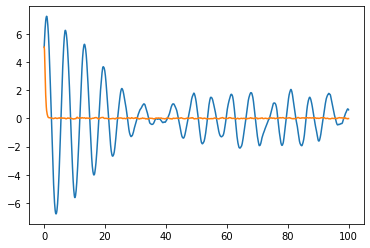

In [34]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5.], [5.]], tf.float32)

trajectory = euler_sde(odeModel_oscillator_control(), y0, t_grid, 1e-2)
y = np.concatenate(trajectory[:,0])
ydot = np.concatenate(trajectory[:,1])
trajectory.shape

# plt.plot(t_grid,free_trajectory, t_grid,y)
plt.plot(t_free,free_trajectory, t_grid,y)
plt.show()

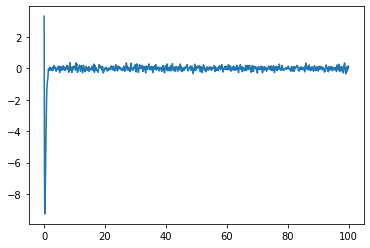

In [35]:
plt.plot(t_grid,ydot)
plt.show()

# Oscillator with NN controller

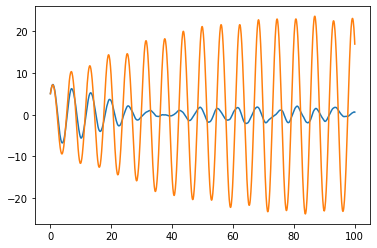

In [41]:
time_steps = 1000
t_grid = np.linspace(0, 100, time_steps)
y0 = tf.cast([[5.], [5.]],tf.float32)

# Run forward evaluation
trajectory = euler_sde(md.oscillator_NNcontrol_sde(), y0, t_grid, 1e-2)
trajectory = np.concatenate(trajectory[:,0,0])

plt.plot(t_free,free_trajectory, t_grid,trajectory)

# Train

In [42]:
def get_batch(batch_size):
    return tf.random_uniform([batch_size,2,1], minval=-15.,maxval=15.)

In [43]:
# Function for gradient evaluation and update
optimizer = tf.train.MomentumOptimizer(learning_rate=1e-5, momentum=0.95)

def compute_gradients_and_update_path(batch_y0):
    with tf.GradientTape() as g:
        
        y_points = euler_sde(model, batch_y0, t_grid, 1e-1)
        loss = tf.reduce_mean(tf.math.square(y_points), axis=0) # Across time
        loss = tf.reduce_mean(loss, axis=0) # Across batches
    
    gradients = g.gradient(loss, model.weights)  # tensorflow gradient computation
    print(gradients)
    optimizer.apply_gradients(zip(gradients, model.weights))
    return loss[0]

# compute_gradients_and_update_path = tfe.defun(compute_gradients_and_update_path) # May make the code faster

In [51]:
# Set up parameters
time_steps = 50
t_grid = np.linspace(0, 50, time_steps)

# Free system for comparison
free_trajectory = euler_self_tlist(md.oscillator(), y0, t_grid, 1e-2)
free_trajectory = np.concatenate(free_trajectory[:,0])

# Initialise new instance of the model
model = md.oscillator_NNcontrol_sde()
# model = md.oscillator_linear_control()

batch_size = 50
niters = 50
test_freq = 15
loss_history = []

tf.Tensor([0.21750721], shape=(1,), dtype=float32)


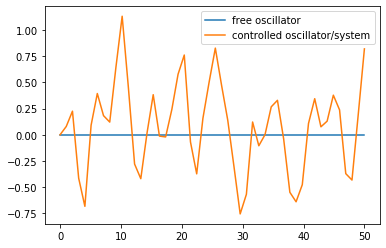

tf.Tensor([0.1745094], shape=(1,), dtype=float32)


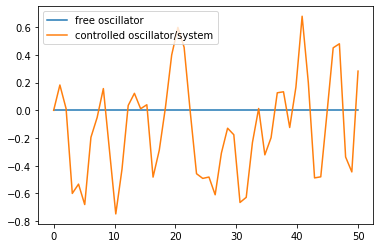

tf.Tensor([0.23360388], shape=(1,), dtype=float32)


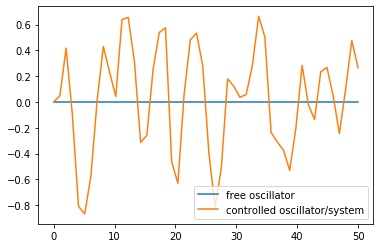

tf.Tensor([0.17289937], shape=(1,), dtype=float32)


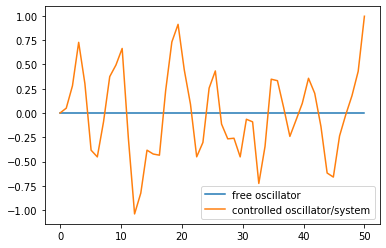

In [61]:
# Run simulation niters times, updating parameters on each iteration
y0 = tf.cast([[0.], [0.]],tf.float32)
for step in range(niters+1):
    
    # batch_y0 = get_batch(batch_size) # Random
    batch_y0 = [y0,y0,y0,y0,y0] # Fixed
    
    loss = compute_gradients_and_update_path(batch_y0)    
    loss_history.append(loss.numpy())
    
    if step % test_freq == 0:        
        trajectory = euler_sde(model, y0, t_grid, 1e-2)        
        print(loss)
        
        trajectory = np.concatenate(trajectory[:,0,0])
        plt.plot(t_grid,free_trajectory, t_grid,trajectory)
        plt.legend( ('free oscillator', 'controlled oscillator/system'))
        plt.show()

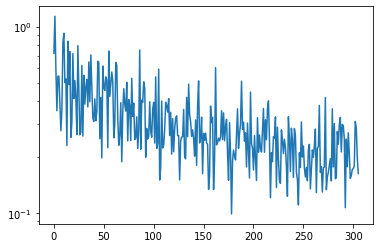

In [63]:
plt.plot(loss_history)
plt.yscale("log")